# Prepare dataset

In [ ]:
!git clone -q https://github.com/amnghd/Persian_poems_corpus.git

In [ ]:
import os
# Read data from directory and saved data and corresponding label as list
# 10 poems
data =[]
labels = []
poets = {'jami' : 9, 'vahshi' : 8, 'khaghani' : 7, 'shahnematollah' : 6, 'nezari' : 5 , 'seyf' : 4, 'sanaee' : 3, 'salman' : 2, 'saeb' : 1, 'saadi' : 0}

for label, poet in enumerate(poets.keys()):
    path = os.path.join('/content/Persian_poems_corpus/normalized', f'{poet}_norm.txt')
    with open(path) as f:
        line = f.readlines()
        #int(len(line[2:]) / 2)
        for i in range(8000):
            if (line[i] == " ") or (line[i] == "\n") or (line[i] == "\t"):
                continue
            data.append(line[2*i].replace("\n","") + " " + line[2*i + 1].replace("\n",""))
            labels.append(label)

In [ ]:
import os

path = '/content/Persian_poems_corpus/normalized'
poets_directory = os.listdir(path)

for poet_path in poets_directory:
  new_path = os.path.join(path, poet_path)
  with open(new_path) as f:
    name = poet_path.split('_')[0]
    line = f.readlines()
    if name in poets.keys():
      print(poet_path, len(line))

saadi_norm.txt 32921
khaghani_norm.txt 36527
vahshi_norm.txt 21681
saeb_norm.txt 16351
seyf_norm.txt 26019
nezari_norm.txt 20461
salman_norm.txt 29361
sanaee_norm.txt 57715
jami_norm.txt 66207
shahnematollah_norm.txt 30105


In [ ]:
# Split procedure

from sklearn.model_selection import train_test_split

# 80% : train  ,   20% : test
# from train_set ----->  train : 75%   ,    val : 25%
X, X_test, y, y_test = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)
# X_val, y_val = X_train[int(len(X_train) * 0.75):] , y_train[int(len(y_train) * 0.75):]
# X_train, y_train = X_train[:int(len(X_train) * 0.75)] , y_train[:int(len(y_train) * 0.75)]

print(f"Length of train dataset is {len(X_train)}")
print(f"Length of val dataset is {len(X_val)}")
print(f"Length of test dataset is {len(X_test)}")



Length of train dataset is 46968
Length of val dataset is 15657
Length of test dataset is 15657


# Part1

## Install and load ParsBERT

In [ ]:
# Install transformers

!pip -q install transformers


In [ ]:
# Cell ParsBERT
# Apply ParsBert and tokenizer

from transformers import AutoConfig, AutoTokenizer, AutoModel, TFAutoModel

tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-fa-base-uncased")
bert = AutoModel.from_pretrained("HooshvareLab/bert-fa-base-uncased")

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Create tokenizer and dataloader

In [ ]:
# Create dataloader

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler


train_set = (X_train, y_train)
test_set = (X_test, y_test)
val_set = (X_val, y_val)

tokens_train = tokenizer(
    train_set[0],
    max_length = 15,
    padding=True,
    truncation=True,
    return_token_type_ids=False
)
tokens_test = tokenizer(
    test_set[0],
    max_length = 15,
    padding=True,
    truncation=True,
    return_token_type_ids=False
)

tokens_val = tokenizer(
    val_set[0],
    max_length = 15,
    padding=True,
    truncation=True,
    return_token_type_ids=False
)

train_seq = torch.tensor(tokens_train['input_ids'])
test_seq = torch.tensor(tokens_test['input_ids'])
val_seq = torch.tensor(tokens_val['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
test_mask = torch.tensor(tokens_test['attention_mask'])
val_mask = torch.tensor(tokens_val['attention_mask'])
y_train_new = torch.tensor(train_set[1])
y_test_new = torch.tensor(test_set[1])
y_val_new = torch.tensor(val_set[1])
train_data = TensorDataset(train_seq, train_mask, y_train_new)
test_data = TensorDataset(test_seq, test_mask, y_test_new)
val_data = TensorDataset(val_seq, val_mask, y_val_new)

# DataLoader for train set
batch_size = 32
train_dataloader = DataLoader(train_data, sampler=None, batch_size=batch_size)
test_dataloader = DataLoader(test_data, sampler=None, batch_size=batch_size)
val_dataloader = DataLoader(val_data, sampler=None, batch_size=batch_size)

## Model and configuration

In [ ]:
import torch.nn as nn

class BERT_Arch(nn.Module):
   def __init__(self, bert, intents):      
       super(BERT_Arch, self).__init__()
       self.bert = bert 
       self.intents = intents      
       # relu activation function
       #  self.relu =  nn.ReLU()
       # dense layer
       self.fc2 = nn.Linear(768,self.intents)
       self.softmax = nn.LogSoftmax(dim=1)
   def forward(self, sent_id, mask):
      #pass the inputs to the model  
      cls_hs = self.bert(sent_id, attention_mask=mask)[0][:,0]
      x = self.fc2(cls_hs)
      x = self.softmax(x)
      return x

In [ ]:
device = torch.device("cuda:0" if torch. cuda. is_available() else "cpu")

# Freeze BERT SECTION
for param in bert.parameters():
    param.requires_grad = False
numberOfcls = 10
model = BERT_Arch(bert, intents = numberOfcls)
model = model.to(device)


In [ ]:
from transformers import AdamW
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch

def configuration(model, train_set, optimizer_type = 'adam'):
    lr = 0.0001
    # Define class_weight for model
    class_weight = 'balanced'
    if(optimizer_type == 'adam'):
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif(optimizer_type == 'sgd'):
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    class_wts = compute_class_weight(class_weight= class_weight, 
                                    classes = np.unique(train_set[1]), 
                                    y = train_set[1])
    weights= torch.tensor(class_wts,dtype=torch.float)
    weights = weights.to(device)
    # LOSS
    loss = torch.nn.CrossEntropyLoss(weight=weights)
    return loss, optimizer, 

loss, optimizer = configuration(model, train_set, optimizer_type = 'adam')

## Train and test procedure

In [ ]:
from sklearn.metrics import f1_score


# Define f1_micro with sklearn package
def f1_measure(y_true, y_pred):
    y_prediction = y_pred.argmax(1)
    y_true_list = y_true.tolist()
    y_pred_list = y_prediction.tolist()
    f1_micro = f1_score(y_true_list, y_pred_list, average='micro')
    return f1_micro

In [ ]:
# Train functiom

def train_loop(device, model, model_loss, epochs, dataloaders, optimizer):
  
  size = len(dataloaders['train'].dataset)
  num_batches = len(dataloaders['train'])
  model.train()
  f1_value, total_loss, correct = 0, 0, 0
  
  train_total_preds=[]
  
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.9)
  for step,batch in enumerate(dataloaders['train']):
    
    batch = [r.to(device) for r in batch] 
    sent_id, mask, labels = batch

    preds = model(sent_id, mask)
    correct += (preds.argmax(1) == labels).type(torch.float).sum().item()
    f1_value += f1_measure(labels, preds)

    loss = model_loss(preds, labels)
    total_loss = total_loss + loss.item()
    loss.backward()
    # nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    optimizer.step()
    optimizer.zero_grad()
  
    # lr_sch.step()
    preds=preds.detach().cpu().numpy()
    train_total_preds.append(preds)
  train_epoch_acc = correct / size
  train_avg_loss = total_loss / num_batches
  train_total_preds  = np.concatenate(train_total_preds, axis=0)
  train_f1_metric = f1_value / num_batches
    
  train_packs = {'train_avg_loss' : train_avg_loss, 'train_total_preds': train_total_preds, 
                 'train_epoch_acc': train_epoch_acc, 'train_f1_metric' : train_f1_metric}

  size = len(dataloaders['val'].dataset)
  num_batches = len(dataloaders['val'])
  f1_value,total_loss, correct = 0, 0, 0
  recal = 0
  val_total_preds=[]
  with torch.no_grad():
    for step,batch in enumerate(dataloaders['val']):
      # if step % 50 == 0 and not step == 0:
      #   print('  Batch {:>5,}  of  {:>5,}.'.format(step,    len(dataloader)))
      batch = [r.to(device) for r in batch] 
      sent_id, mask, labels = batch
      preds = model(sent_id, mask)
      correct += (preds.argmax(1) == labels).type(torch.float).sum().item()
      f1_value += f1_measure(labels, preds)
      loss = model_loss(preds, labels)
      total_loss = total_loss + loss.item()
      # nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      preds=preds.detach().cpu().numpy()
      val_total_preds.append(preds)
    val_epoch_acc = correct / size
    val_avg_loss = total_loss / num_batches
    val_total_preds  = np.concatenate(val_total_preds, axis=0)

    val_f1_metric = f1_value / num_batches

  val_packs = {'val_avg_loss' : val_avg_loss, 'val_total_preds': val_total_preds, 
                 'val_epoch_acc': val_epoch_acc, 'val_f1_metric' : val_f1_metric}
  return train_packs, val_packs, model

In [ ]:
def test_loop(device, model, model_loss, dataloader):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  f1_value,total_loss, correct = 0, 0, 0
  recal = 0
  total_preds=[]
  with torch.no_grad():
    for step,batch in enumerate(dataloader):
      # if step % 50 == 0 and not step == 0:
      #   print('  Batch {:>5,}  of  {:>5,}.'.format(step,    len(dataloader)))
      batch = [r.to(device) for r in batch] 
      sent_id, mask, labels = batch
      preds = model(sent_id, mask)
      correct += (preds.argmax(1) == labels).type(torch.float).sum().item()
      f1_value += f1_measure(labels, preds)
      loss = model_loss(preds, labels)
      total_loss = total_loss + loss.item()
      # nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      preds=preds.detach().cpu().numpy()
      total_preds.append(preds)
    test_acc = correct / size
    avg_loss = total_loss / num_batches
    total_preds  = np.concatenate(total_preds, axis=0)

    f1_metric = f1_value / num_batches

    return avg_loss, total_preds, test_acc, f1_metric,  model

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import torch

def confusion_matrix(classes, y_pred, dataloader, dataset_type):
  #____________________Confusion matrix_______________

  print("classes", classes)
  #classes = [get_display(reshape(label)) for label in classes]

  d = len(classes)
  Y = (dataloader.dataset[:][2]).detach().cpu().numpy()
  confusion_matrix = np.ones((d, d))
  for i in range(d):
      for j in range(d):
          confusion_matrix [i, j] = (np.sum((y_pred.argmax(axis=1) == j) * (Y == i))) / len(torch.nonzero(torch.tensor((Y == i))))
  def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Oranges):
      plt.figure(figsize=(9,9))
      plt.imshow(cm, interpolation='nearest', cmap=cmap)
      plt.title(title)
      plt.colorbar()
      tick_marks = np.arange(cm.shape[1])
      plt.xticks(tick_marks,classes,rotation=90)
      ax = plt.gca()
      plt.yticks(tick_marks,classes)

      thresh = cm.max() / 2.
      for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
          plt.text(j, i, format(cm[i, j], '.1f'),
                  horizontalalignment="center",
                  color="white" if cm[i, j] > thresh else "black")

      plt.tight_layout()
      plt.ylabel('True label')
      plt.xlabel('Predicted label')

  np.set_printoptions(precision=1) 
  print(f'Confusion matrix of {dataset_type} dataset is : \n ', confusion_matrix)
  plot_confusion_matrix(confusion_matrix)


Training start:..

 Epoch 1 / 15
#######################################################

Training Loss: 2.168, 
Training Accuracy: 21.691, 
Training f1: 21.690

val Loss: 2.069, 
val Accuracy: 26.659 
val f1: 26.636

 Epoch 2 / 15
#######################################################

Training Loss: 2.037, 
Training Accuracy: 27.774, 
Training f1: 27.772

val Loss: 2.009, 
val Accuracy: 29.156 
val f1: 29.146

 Epoch 3 / 15
#######################################################

Training Loss: 1.986, 
Training Accuracy: 29.897, 
Training f1: 29.894

val Loss: 1.982, 
val Accuracy: 30.236 
val f1: 30.240

 Epoch 4 / 15
#######################################################

Training Loss: 1.964, 
Training Accuracy: 30.783, 
Training f1: 30.779

val Loss: 1.960, 
val Accuracy: 30.951 
val f1: 30.938

 Epoch 5 / 15
#######################################################

Training Loss: 1.945, 
Training Accuracy: 31.670, 
Training f1: 31.669

val Loss: 1.948, 
val Accuracy: 31.226 
va

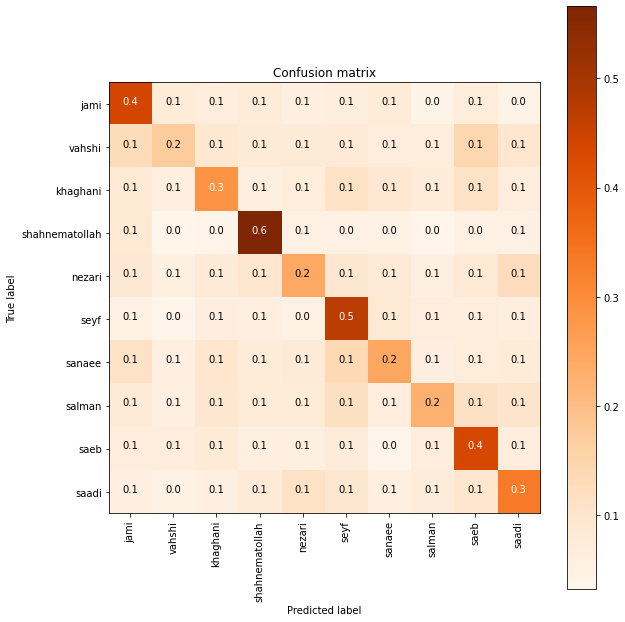

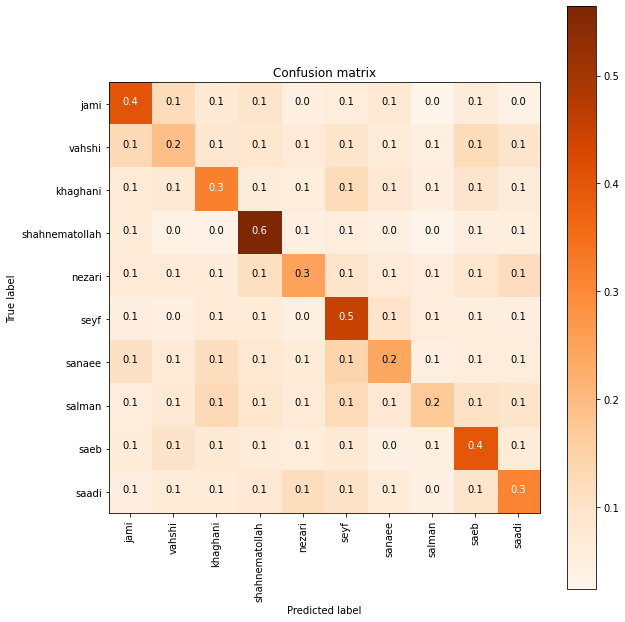

In [ ]:
# Train process

dataloaders = {'train' : train_dataloader, 'val' : val_dataloader, 'test' : test_dataloader}

print("Training start:..")
epochs = 15

val_acc = 0
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)
for epoch in range(epochs):
    
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    train_packs, val_packs, model = train_loop(device = device, model = model, model_loss = loss, 
                                                    epochs = epochs, dataloaders = dataloaders, optimizer = optimizer)
    scheduler.step()
    train_loss = train_packs['train_avg_loss']
    train_pred = train_packs['train_total_preds']
    train_accuracy = train_packs['train_epoch_acc']  
    train_f1_score = train_packs['train_f1_metric']  

    val_loss = val_packs['val_avg_loss']
    val_pred = val_packs['val_total_preds']
    val_accuracy = val_packs['val_epoch_acc']  
    val_f1_score = val_packs['val_f1_metric']
    if val_accuracy > val_acc:
        val_acc = val_accuracy
        torch.save(model, 'model_step.pt')

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print("#######################################################")
    print(f'\nTraining Loss: {train_loss:.3f}, \nTraining Accuracy: {100*train_accuracy:.3f}, \nTraining f1: {100*train_f1_score:.3f}')
    print(f'\nval Loss: {val_loss:.3f}, \nval Accuracy: {100*val_accuracy:.3f} \nval f1: {100*val_f1_score:.3f}')    

classes = [cls for cls in poets.keys()]
confusion_matrix(classes = classes, y_pred = train_pred, dataloader = dataloaders['train'], dataset_type='step1_train')
confusion_matrix(classes = classes, y_pred = val_pred, dataloader = dataloaders['val'], dataset_type='step1_val')


test Loss: 1.922, 
test Accuracy: 32.554 
test f1: 32.523
classes ['jami', 'vahshi', 'khaghani', 'shahnematollah', 'nezari', 'seyf', 'sanaee', 'salman', 'saeb', 'saadi']
Confusion matrix of step1_test dataset is : 
  [[0.4 0.1 0.1 0.1 0.1 0.1 0.1 0.  0.1 0. ]
 [0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.3 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.  0.  0.6 0.1 0.1 0.1 0.  0.1 0. ]
 [0.1 0.1 0.1 0.1 0.2 0.1 0.1 0.  0.1 0.1]
 [0.1 0.  0.1 0.1 0.  0.4 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.2 0.2 0.  0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.2 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.  0.1 0.4 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.3]]


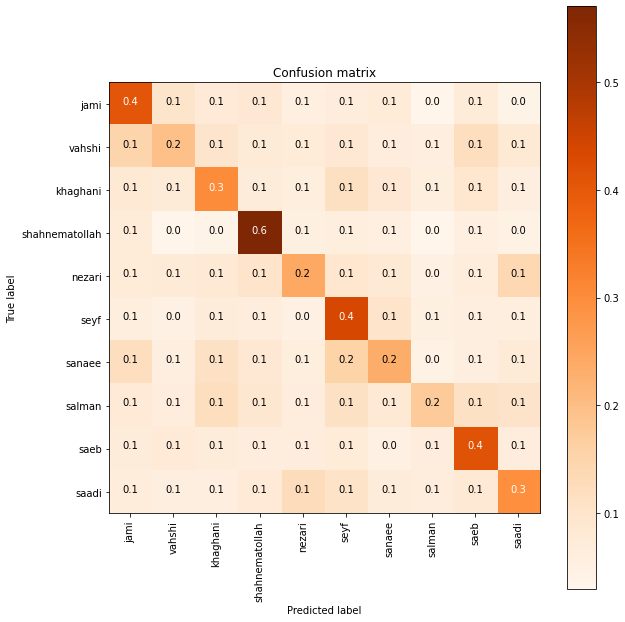

In [ ]:
# Test process

test_loss, test_pred, test_acc, test_f1_metric,  model = test_loop(device, model, loss, dataloaders['test'])
print(f'\ntest Loss: {test_loss:.3f}, \ntest Accuracy: {100*test_acc:.3f} \ntest f1: {100*test_f1_metric:.3f}')    
confusion_matrix(classes = classes, y_pred = test_pred, dataloader = dataloaders['test'], dataset_type='step1_test')

# Part2

## Adam optimizer

In [ ]:
# Cell ParsBERT
# Apply ParsBert and tokenizer

from transformers import AutoConfig, AutoTokenizer, AutoModel, TFAutoModel

tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-fa-base-uncased")
bert = AutoModel.from_pretrained("HooshvareLab/bert-fa-base-uncased")

In [ ]:
import torch.nn as nn

class BERT_Arch(nn.Module):
   def __init__(self, bert, intents):      
       super(BERT_Arch, self).__init__()
       self.bert = bert 
       self.intents = intents      
       # relu activation function
       #  self.relu =  nn.ReLU()
       # dense layer
       self.fc2 = nn.Linear(768,self.intents)
       self.softmax = nn.LogSoftmax(dim=1)
       self.DropOut = nn.Dropout(0.7)
   def forward(self, sent_id, mask):
      #pass the inputs to the model  
      cls_hs = self.bert(sent_id, attention_mask=mask)[0][:,0]
      x = self.DropOut(cls_hs)
      x = self.fc2(x)
      x = self.softmax(x)
      return x

In [ ]:
device = torch.device("cuda:0" if torch. cuda. is_available() else "cpu")

# Now train whole of network
for param in bert.parameters():
    param.requires_grad = True
numberOfcls = 10
model = BERT_Arch(bert, intents = numberOfcls)
model = model.to(device)

In [ ]:
from transformers import AdamW
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch

def configuration(model, train_set, optimizer_type = 'adam'):
    lr = lr = 0.00005
    # Define class_weight for model
    class_weight = 'balanced'
    if(optimizer_type == 'adam'):
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif(optimizer_type == 'sgd'):
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    class_wts = compute_class_weight(class_weight= class_weight, 
                                    classes = np.unique(train_set[1]), 
                                    y = train_set[1])
    weights= torch.tensor(class_wts,dtype=torch.float)
    weights = weights.to(device)
    # LOSS
    loss = torch.nn.CrossEntropyLoss(weight=weights)
    return loss, optimizer, 

loss, optimizer = configuration(model, train_set, optimizer_type = 'adam')

Training start:..

 Epoch 1 / 10
#######################################################

Training Loss: 1.719, 
Training Accuracy: 40.879, 
Training f1: 40.880

val Loss: 1.448, 
val Accuracy: 50.699 
val f1: 50.641

 Epoch 2 / 10
#######################################################

Training Loss: 1.145, 
Training Accuracy: 61.819, 
Training f1: 61.820

val Loss: 1.401, 
val Accuracy: 55.106 
val f1: 55.091

 Epoch 3 / 10
#######################################################

Training Loss: 0.760, 
Training Accuracy: 75.185, 
Training f1: 75.186

val Loss: 1.633, 
val Accuracy: 54.563 
val f1: 54.532

 Epoch 4 / 10
#######################################################

Training Loss: 0.513, 
Training Accuracy: 83.523, 
Training f1: 83.524

val Loss: 1.825, 
val Accuracy: 53.861 
val f1: 53.847

 Epoch 5 / 10
#######################################################

Training Loss: 0.372, 
Training Accuracy: 88.086, 
Training f1: 88.085

val Loss: 1.948, 
val Accuracy: 52.877 
va

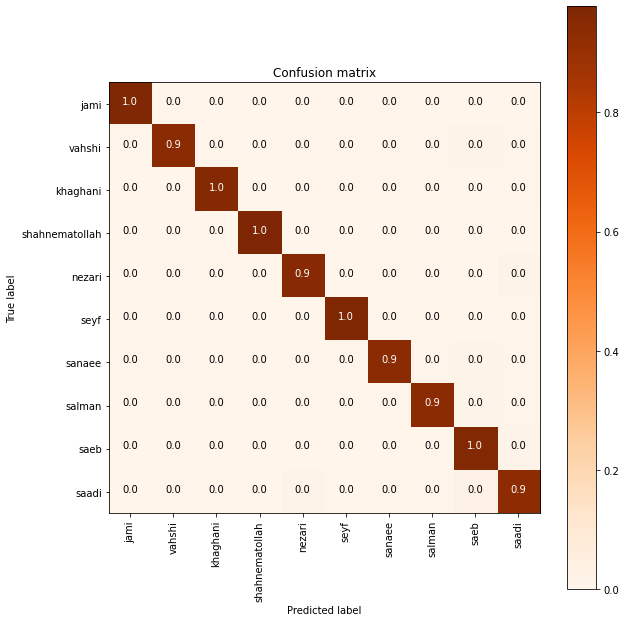

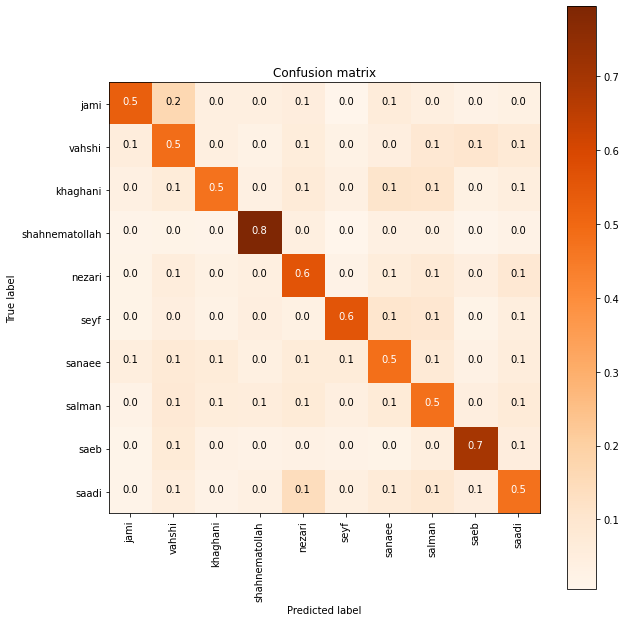

In [ ]:
# Train process

dataloaders = {'train' : train_dataloader, 'val' : val_dataloader, 'test' : test_dataloader}

print("Training start:..")
epochs = 10

for epoch in range(epochs):
    
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    train_packs, val_packs, model = train_loop(device = device, model = model, model_loss = loss, 
                                                    epochs = epochs, dataloaders = dataloaders, optimizer = optimizer)
    train_loss = train_packs['train_avg_loss']
    train_pred = train_packs['train_total_preds']
    train_accuracy = train_packs['train_epoch_acc']  
    train_f1_score = train_packs['train_f1_metric']  

    val_loss = val_packs['val_avg_loss']
    val_pred = val_packs['val_total_preds']
    val_accuracy = val_packs['val_epoch_acc']  
    val_f1_score = val_packs['val_f1_metric'] 

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print("#######################################################")
    print(f'\nTraining Loss: {train_loss:.3f}, \nTraining Accuracy: {100*train_accuracy:.3f}, \nTraining f1: {100*train_f1_score:.3f}')
    print(f'\nval Loss: {val_loss:.3f}, \nval Accuracy: {100*val_accuracy:.3f} \nval f1: {100*val_f1_score:.3f}')    

classes = [cls for cls in poets.keys()]
confusion_matrix(classes = classes, y_pred = train_pred, dataloader = dataloaders['train'], dataset_type='step1_train')
confusion_matrix(classes = classes, y_pred = val_pred, dataloader = dataloaders['val'], dataset_type='step1_val')


test Loss: 2.301, 
test Accuracy: 55.062 
test f1: 55.030
classes ['jami', 'vahshi', 'khaghani', 'shahnematollah', 'nezari', 'seyf', 'sanaee', 'salman', 'saeb', 'saadi']
Confusion matrix of step1_test dataset is : 
  [[0.5 0.2 0.  0.  0.  0.  0.1 0.  0.  0. ]
 [0.  0.5 0.  0.  0.1 0.  0.  0.1 0.1 0.1]
 [0.  0.1 0.5 0.  0.1 0.  0.1 0.1 0.  0. ]
 [0.  0.  0.  0.8 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.6 0.  0.1 0.1 0.  0.1]
 [0.  0.  0.  0.  0.1 0.6 0.1 0.1 0.  0. ]
 [0.1 0.1 0.1 0.  0.1 0.1 0.5 0.1 0.  0.1]
 [0.  0.1 0.1 0.1 0.1 0.  0.1 0.5 0.1 0.1]
 [0.  0.1 0.  0.  0.  0.  0.  0.1 0.6 0.1]
 [0.  0.1 0.  0.  0.2 0.  0.1 0.1 0.1 0.5]]


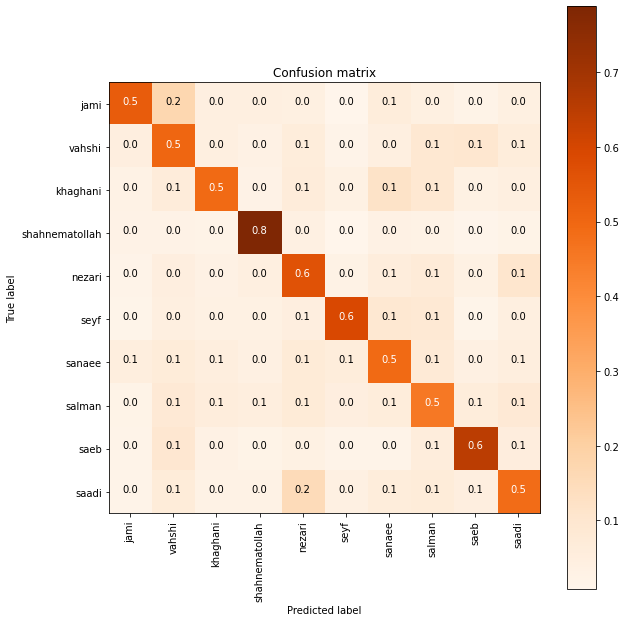

In [ ]:
# Test process

test_loss, test_pred, test_acc, test_f1_metric,  model = test_loop(device, model, loss, dataloaders['test'])
print(f'\ntest Loss: {test_loss:.3f}, \ntest Accuracy: {100*test_acc:.3f} \ntest f1: {100*test_f1_metric:.3f}')    
confusion_matrix(classes = classes, y_pred = test_pred, dataloader = dataloaders['test'], dataset_type='step1_test')

## SGD optimizer

In [ ]:
# Cell ParsBERT
# Apply ParsBert and tokenizer

from transformers import AutoConfig, AutoTokenizer, AutoModel, TFAutoModel

tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-fa-base-uncased")
bert = AutoModel.from_pretrained("HooshvareLab/bert-fa-base-uncased")

In [ ]:
device = torch.device("cuda:0" if torch. cuda. is_available() else "cpu")

# Now train whole of network
for param in bert.parameters():
    param.requires_grad = True
numberOfcls = 10
model = BERT_Arch(bert, intents = numberOfcls)
model = model.to(device)

In [ ]:
from transformers import AdamW
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch

def configuration(model, train_set, optimizer_type = 'adam'):
    lr = 0.00005
    # Define class_weight for model
    class_weight = 'balanced'
    if(optimizer_type == 'adam'):
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif(optimizer_type == 'sgd'):
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    class_wts = compute_class_weight(class_weight= class_weight, 
                                    classes = np.unique(train_set[1]), 
                                    y = train_set[1])
    weights= torch.tensor(class_wts,dtype=torch.float)
    weights = weights.to(device)
    # LOSS
    loss = torch.nn.CrossEntropyLoss(weight=weights)
    return loss, optimizer, 

loss, optimizer = configuration(model, train_set, optimizer_type = 'sgd')

Training start:..

 Epoch 1 / 10
#######################################################

Training Loss: 2.339, 
Training Accuracy: 13.739, 
Training f1: 13.741

val Loss: 2.229, 
val Accuracy: 18.196 
val f1: 18.219

 Epoch 2 / 10
#######################################################

Training Loss: 2.150, 
Training Accuracy: 22.319, 
Training f1: 22.319

val Loss: 2.066, 
val Accuracy: 25.995 
val f1: 26.006

 Epoch 3 / 10
#######################################################

Training Loss: 1.997, 
Training Accuracy: 28.958, 
Training f1: 28.955

val Loss: 1.928, 
val Accuracy: 31.583 
val f1: 31.570

 Epoch 4 / 10
#######################################################

Training Loss: 1.882, 
Training Accuracy: 33.640, 
Training f1: 33.640

val Loss: 1.846, 
val Accuracy: 35.728 
val f1: 35.676

 Epoch 5 / 10
#######################################################

Training Loss: 1.797, 
Training Accuracy: 37.042, 
Training f1: 37.042

val Loss: 1.789, 
val Accuracy: 37.964 
va

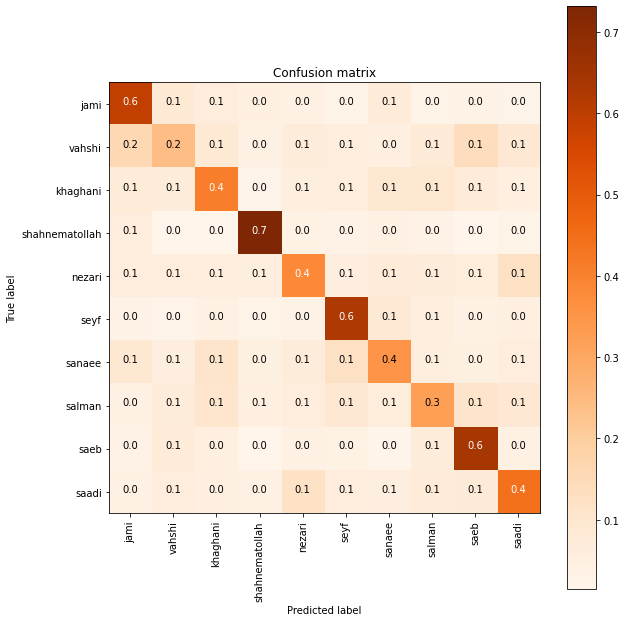

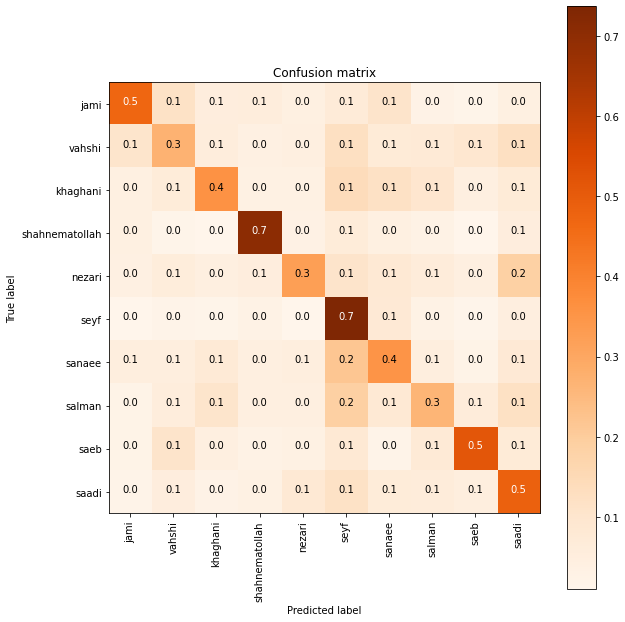

In [ ]:
# Train process

dataloaders = {'train' : train_dataloader, 'val' : val_dataloader, 'test' : test_dataloader}

print("Training start:..")
epochs = 10

for epoch in range(epochs):
    
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    train_packs, val_packs, model = train_loop(device = device, model = model, model_loss = loss, 
                                                    epochs = epochs, dataloaders = dataloaders, optimizer = optimizer)
    train_loss = train_packs['train_avg_loss']
    train_pred = train_packs['train_total_preds']
    train_accuracy = train_packs['train_epoch_acc']  
    train_f1_score = train_packs['train_f1_metric']  

    val_loss = val_packs['val_avg_loss']
    val_pred = val_packs['val_total_preds']
    val_accuracy = val_packs['val_epoch_acc']  
    val_f1_score = val_packs['val_f1_metric'] 

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print("#######################################################")
    print(f'\nTraining Loss: {train_loss:.3f}, \nTraining Accuracy: {100*train_accuracy:.3f}, \nTraining f1: {100*train_f1_score:.3f}')
    print(f'\nval Loss: {val_loss:.3f}, \nval Accuracy: {100*val_accuracy:.3f} \nval f1: {100*val_f1_score:.3f}')    

classes = [cls for cls in poets.keys()]
confusion_matrix(classes = classes, y_pred = train_pred, dataloader = dataloaders['train'], dataset_type='step1_train')
confusion_matrix(classes = classes, y_pred = val_pred, dataloader = dataloaders['val'], dataset_type='step1_val')


test Loss: 1.599, 
test Accuracy: 44.734 
test f1: 44.701
classes ['jami', 'vahshi', 'khaghani', 'shahnematollah', 'nezari', 'seyf', 'sanaee', 'salman', 'saeb', 'saadi']
Confusion matrix of step1_test dataset is : 
  [[0.5 0.1 0.1 0.1 0.  0.1 0.1 0.  0.  0. ]
 [0.1 0.3 0.1 0.  0.  0.1 0.1 0.1 0.1 0.1]
 [0.  0.1 0.4 0.  0.  0.1 0.1 0.1 0.  0.1]
 [0.  0.  0.  0.7 0.  0.  0.  0.  0.  0. ]
 [0.  0.1 0.  0.1 0.3 0.1 0.1 0.1 0.  0.2]
 [0.  0.  0.  0.  0.  0.7 0.1 0.  0.  0. ]
 [0.1 0.1 0.1 0.  0.  0.2 0.4 0.1 0.  0.1]
 [0.  0.1 0.1 0.  0.  0.2 0.1 0.3 0.1 0.1]
 [0.  0.1 0.1 0.  0.  0.1 0.  0.1 0.5 0.1]
 [0.  0.1 0.  0.  0.1 0.1 0.1 0.1 0.  0.5]]


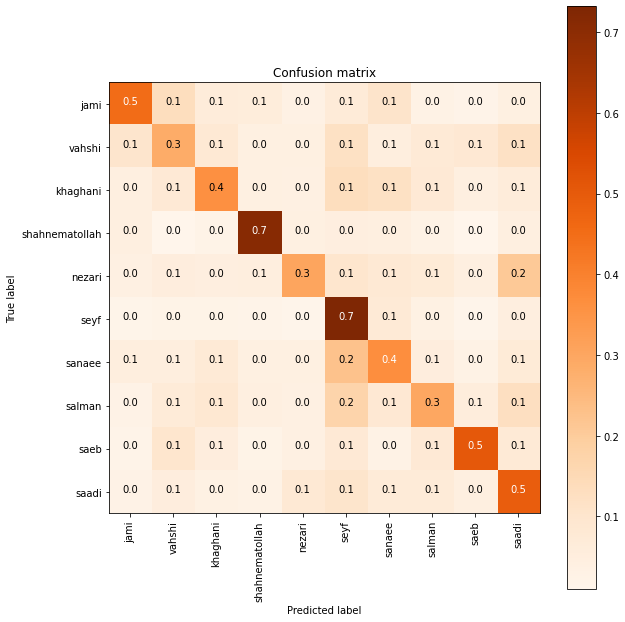

In [ ]:
# Test process

test_loss, test_pred, test_acc, test_f1_metric,  model = test_loop(device, model, loss, dataloaders['test'])
print(f'\ntest Loss: {test_loss:.3f}, \ntest Accuracy: {100*test_acc:.3f} \ntest f1: {100*test_f1_metric:.3f}')    
confusion_matrix(classes = classes, y_pred = test_pred, dataloader = dataloaders['test'], dataset_type='step1_test')

# Part3(preplexity)

In [ ]:
# data list was our main dataset

import random

random_data = []
random_label = []
for count in range(1000):
    random_idx = random.randint(0,len(data))
    random_data.append(data[random_idx])
    random_label.append(labels[random_idx])



In [ ]:
random_set = (random_data, random_label)

tokens_random = tokenizer(
    random_set[0],
    max_length = 20,
    padding=True,
    truncation=True,
    return_token_type_ids=False
)
random_seq = torch.tensor(tokens_random['input_ids'])

random_mask = torch.tensor(tokens_random['attention_mask'])

y_random_new = torch.tensor(random_set[1])

random_data = TensorDataset(random_seq, random_mask, y_random_new)

batch_size = 32

random_dataloader = DataLoader(random_data, sampler=None, batch_size=batch_size)



In [ ]:
device = torch.device("cuda:0" if torch. cuda. is_available() else "cpu")

import torch.nn as nn

class BERT_Arch(nn.Module):
   def __init__(self, bert, intents):      
       super(BERT_Arch, self).__init__()
       self.bert = bert 
       self.intents = intents      
       # relu activation function
       #  self.relu =  nn.ReLU()
       # dense layer
       self.fc2 = nn.Linear(768,self.intents)
       self.softmax = nn.LogSoftmax(dim=1)
   def forward(self, sent_id, mask):
      #pass the inputs to the model  
      cls_hs = self.bert(sent_id, attention_mask=mask)[0][:,0]
      x = self.fc2(cls_hs)
      x = self.softmax(x)
      return x

new_model = torch.load('/content/model_step.pt',map_location=device)

In [ ]:
# Compute preplexity befor and after applying model


def test_loop(device, model, model_loss, dataloader):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  befor_total_loss= 0
  after_total_loss= 0
  with torch.no_grad():
    for step,batch in enumerate(dataloader):
      batch = [r.to(device) for r in batch] 
      sent_id, mask, labels = batch
      preds = model(sent_id, mask)
      random_pred = torch.rand(preds.shape[0],10)
      random_pred = random_pred.to(device)
      befor_loss = model_loss(random_pred, labels)
      after_loss = model_loss(preds, labels)
      befor_total_loss = befor_total_loss + befor_loss.item()
      after_total_loss = after_total_loss + after_loss.item()
      nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    befor_avg_loss = befor_total_loss / num_batches
    after_avg_loss = after_total_loss / num_batches
    print(f"Preplexity befor applying model is {torch.exp(torch.tensor(befor_avg_loss))}")
    print(f"Preplexity after applying model is {torch.exp(torch.tensor(after_avg_loss))}")

test_loop(device, new_model, loss, random_dataloader)

Preplexity befor applying model is 10.311067581176758
Preplexity after applying model is 6.700760841369629


**Preplexity has reverse relationship with loss of the model, So the preplexity after applying model has decreased**